<a href="https://colab.research.google.com/github/futartup/eva-session-2/blob/master/session5-Human-Pose-Estimation/HumanPoseEstimation_ONNX_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monocular Single Human Pose Estimation

In [47]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

fatal: destination path 'human-pose-estimation.pytorch' already exists and is not an empty directory.


In [48]:
! pip install onnx onnxruntime

In [49]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [50]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

import cv2

import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [51]:
import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name

We are going to use MPII - ResNet50 Model trained on `256x256` sized images
model_file: https://drive.google.com/file/d/1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc/view?usp=sharing

In [52]:
! gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc

Downloading...
From: https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
To: /content/pose_resnet_50_256x256.pth.tar
136MB [00:01, 86.9MB/s]


The corresponding config file is taken from experiments folder

In [53]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [54]:
update_config(CONFIG_FILE)
config.GPUS = '' # we are running on CPU

Load the model

In [55]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Pose Lady

In [56]:
! wget https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg -O pose.jpg

--2020-08-26 05:39:07--  https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.193.24.222, 2600:1417:76:480::1931, 2600:1417:76:48b::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.193.24.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12170 (12K) [image/jpeg]
Saving to: ‘pose.jpg’

pose.jpg            100%[===================>]  11.88K  --.-KB/s    in 0s      

2020-08-26 05:39:07 (203 MB/s) - ‘pose.jpg’ saved [12170/12170]



Pose Man

In [57]:
! wget https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png -O pose.png

--2020-08-26 05:39:07--  https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving habrastorage.org (habrastorage.org)... 95.213.152.170
Connecting to habrastorage.org (habrastorage.org)|95.213.152.170|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png [following]
--2020-08-26 05:39:09--  https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving hsto.org (hsto.org)... 104.26.13.161, 104.26.12.161, 172.67.71.175, ...
Connecting to hsto.org (hsto.org)|104.26.13.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211894 (207K) [image/png]
Saving to: ‘pose.png’

pose.png            100%[===================>] 206.93K  --.-KB/s    in 0.008s  

2020-08-26 05:39:09 (26.3 MB/s) - ‘pose.png’ saved [211894/211894]



And this is me

In [58]:
! wget https://github.com/futartup/eva-session-2/blob/master/session5-Human-Pose-Estimation/sample.jpg?raw=true -O sample-pose.jpg

--2020-08-26 05:39:09--  https://github.com/futartup/eva-session-2/blob/master/session5-Human-Pose-Estimation/sample.jpg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/futartup/eva-session-2/raw/master/session5-Human-Pose-Estimation/sample.jpg [following]
--2020-08-26 05:39:10--  https://github.com/futartup/eva-session-2/raw/master/session5-Human-Pose-Estimation/sample.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/futartup/eva-session-2/master/session5-Human-Pose-Estimation/sample.jpg [following]
--2020-08-26 05:39:10--  https://raw.githubusercontent.com/futartup/eva-session-2/master/session5-Human-Pose-Estimation/sample.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.1

In [59]:
IMAGE_FILE = 'sample-pose.jpg'

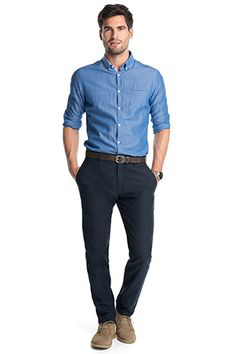

In [60]:
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image

In [61]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

Transform the image for the model

In [62]:
tr_img = transform(image)

Pass the Image through the model

In [63]:
output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

In [64]:
_, OUT_HEIGHT, OUT_WIDTH = output.shape
output.shape

torch.Size([16, 64, 64])

In [65]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

`joint_id` - name
taken from: http://human-pose.mpi-inf.mpg.de/#download

In [66]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [67]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [68]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

Here are all the detections

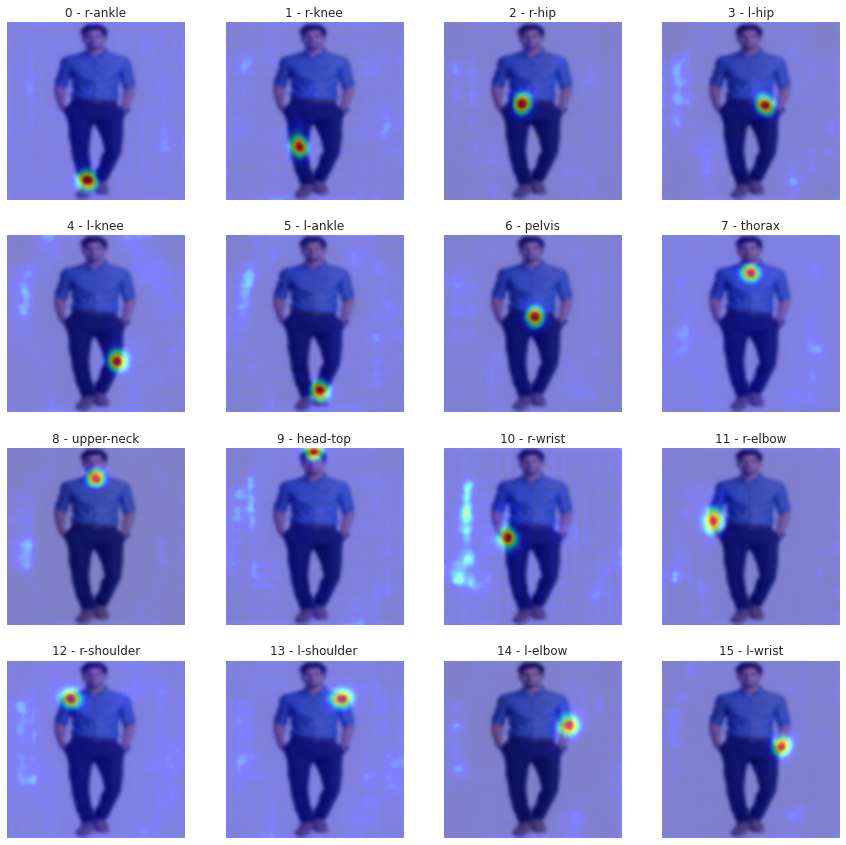

In [69]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

Here are the detections summarised in a single image

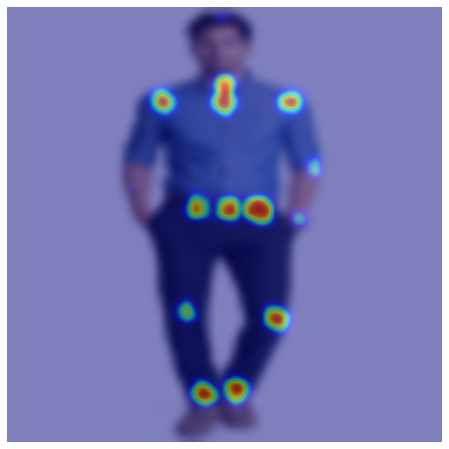

In [70]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

Now we will connect these detected regions

In [71]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

### Our final image with the estimated pose !

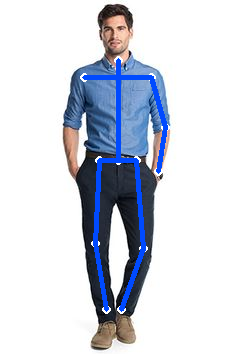

In [72]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))

## Convert to ONNX and quantize the model

In [73]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

PyTorch Model Size

In [74]:
print_size_of_model(model)

Size (MB): 136.326647


In [75]:
new_model = copy.deepcopy(model)

Now we will Convert this model to ONNX

In [76]:
import io
import numpy as np
import torch.onnx

In [77]:
# Input to the model
torch_model = new_model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [78]:
import onnx

onnx_model = onnx.load("simple_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

Let's just check the size of the saved ONNX Model

In [79]:
print_size_of_onnx_model(onnx_model)

Size (MB): 136.247923


And also lets quicky test if the model works

In [80]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [81]:
ort_outs = ort_outs[0][0]

In [82]:
len(ort_outs)

16

### ONNX Model Quantization

In [83]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

In [84]:
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)

In [85]:
onnx.save(quantized_model, 'simple_pose_estimation.quantized.onnx')

The Quantized Model is Half the Size ! (as expected but still yayyy !)

In [86]:
print_size_of_onnx_model(quantized_model)

Size (MB): 65.933789


Let's now test if the quantized model works

In [87]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

In [88]:
np.array(ort_outs).shape

(1, 1, 16, 64, 64)

In [89]:
ort_outs = np.array(ort_outs[0][0])

In [90]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = ort_outs
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

Pretty similar results !? eh ?

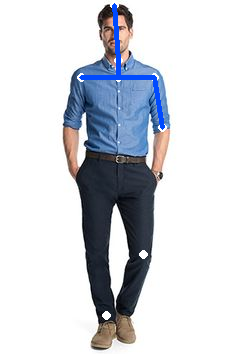

In [91]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))